In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    %tensorflow_version.2.x
except Exception:
    pass

import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_excel(r"C:\Users\kjk66\Downloads\유입유량.xlsx")
df = df.drop(['location', 't', 'date', 'time'], axis=1)

#### 전기간 유입유량

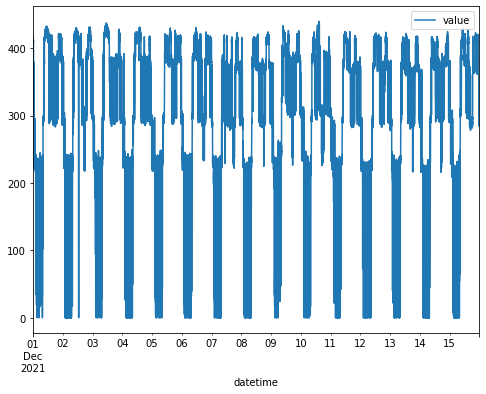

In [3]:
date_time = df['datetime']
plot_cols = ['value']

plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

#### 일별 유입유량

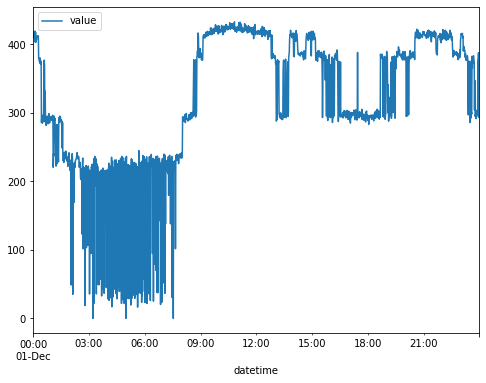

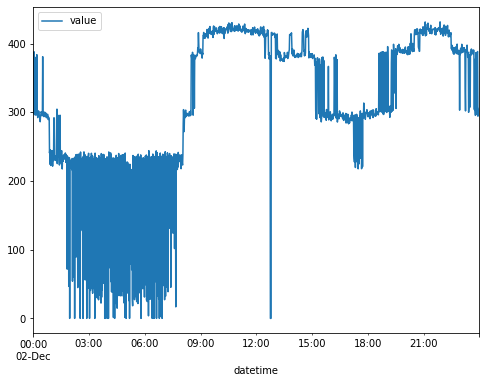

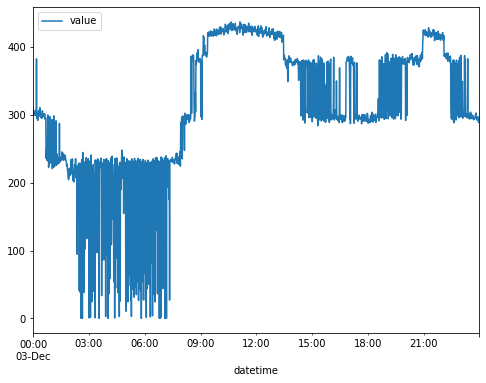

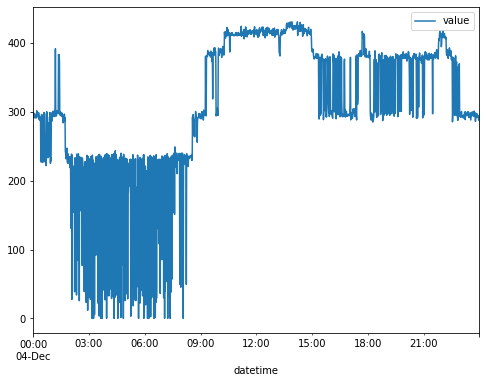

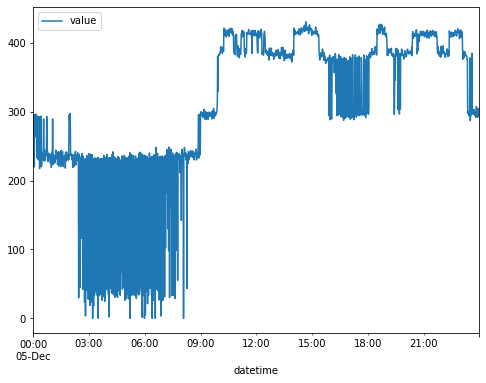

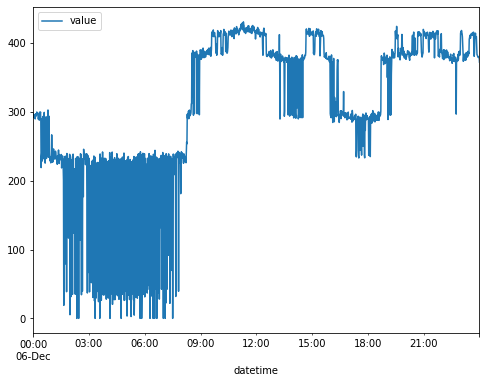

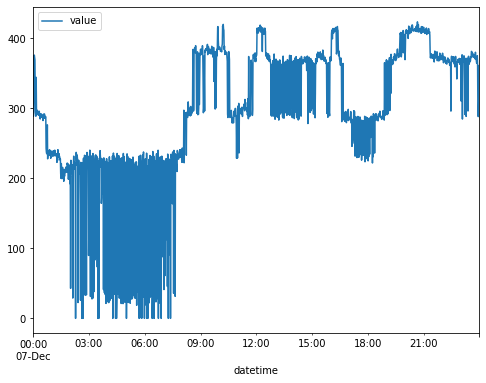

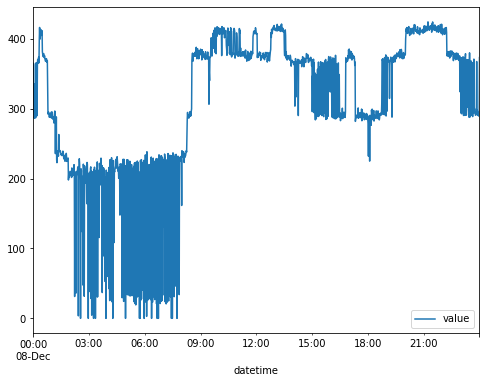

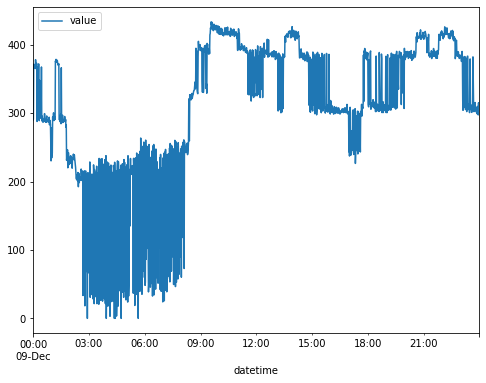

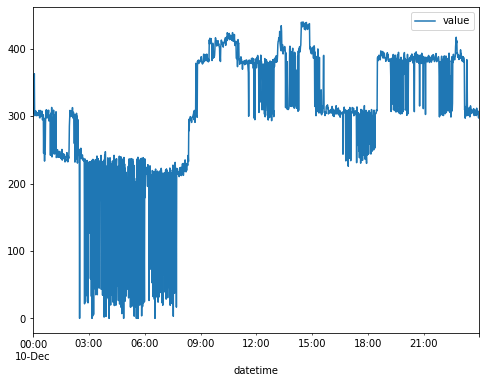

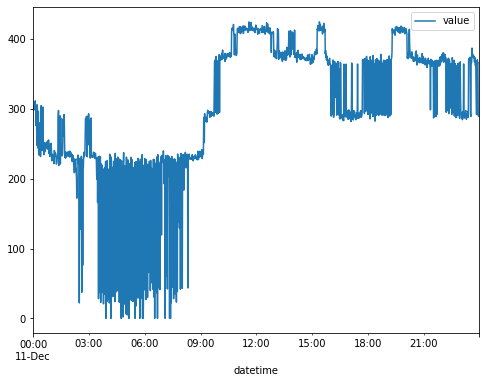

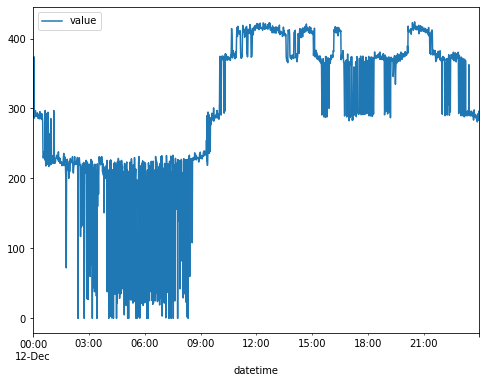

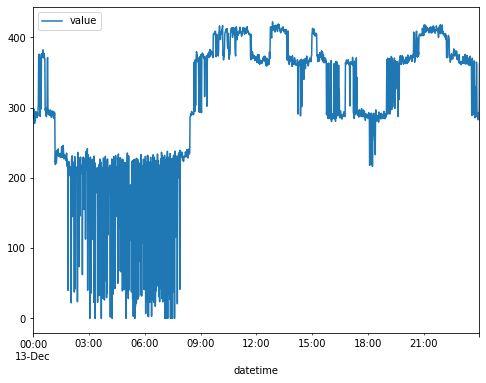

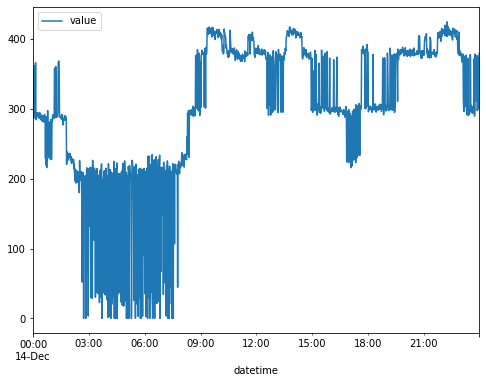

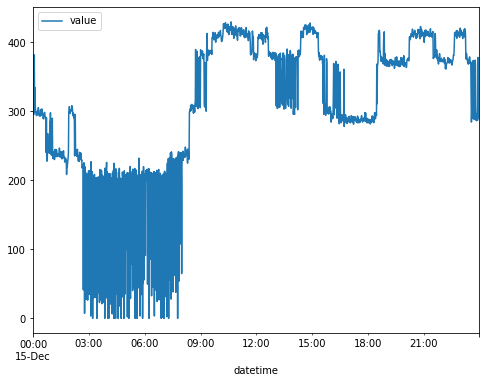

In [4]:
for i in range(1, 16):
    plot_features = df[plot_cols][1440*(i-1):1440*i]
    plot_features.index = date_time[1440*(i-1):1440*i]
    _ = plot_features.plot(subplots=True)

In [5]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i - history_size, i)

        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [6]:
train_split = 20160 # 14일 * 1440
# univariate 시계열 예측

uni_data = df['value']
uni_data.index = df['datetime']
uni_data.head()

datetime
2021-12-01 00:00:00    418.50
2021-12-01 00:01:00    409.95
2021-12-01 00:02:00    410.96
2021-12-01 00:03:00    412.20
2021-12-01 00:04:00    415.01
Name: value, dtype: float64

In [29]:
uni_data.plot(subplots=True);

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [8]:
uni_data = uni_data.values

# 정규화
uni_train_mean = uni_data[:train_split].mean()
uni_train_std = uni_data[:train_split].std()

uni_data_norm = (uni_data - uni_train_mean) / uni_train_std

In [9]:
# 평균 0, 표준편차 1의 정규분포화
uni_data_norm.mean(), uni_data_norm.std()

(0.0015557717472788008, 1.0003976078617731)

In [10]:
history = 24
target = 0

x_train_uni, y_train_uni = univariate_data(uni_data_norm, 0, train_split, history, target)
x_val_uni, y_val_uni = univariate_data(uni_data_norm, train_split, None, history, target)
# x_train_uni, y_train_uni = univariate_data(uni_data, 0, train_split, history, target)
# x_val_uni, y_val_uni = univariate_data(uni_data, train_split, None, history, target)

In [11]:
x_train_uni.shape

(20136, 24, 1)

In [12]:
x_val_uni.shape

(1416, 24, 1)

In [13]:
def create_time_steps(length):
    return list(range(-length, 0))

In [14]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0


    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Tiem-Step')
    return plt

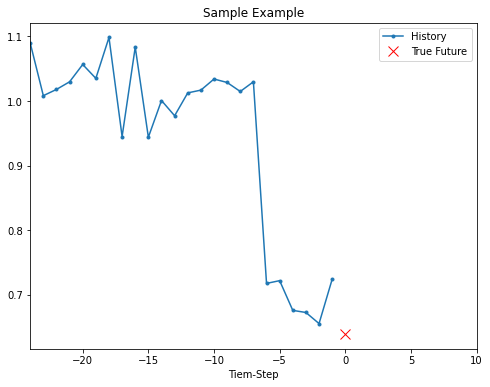

In [15]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example');

In [16]:
def baseline(history):
    return np.mean(history)

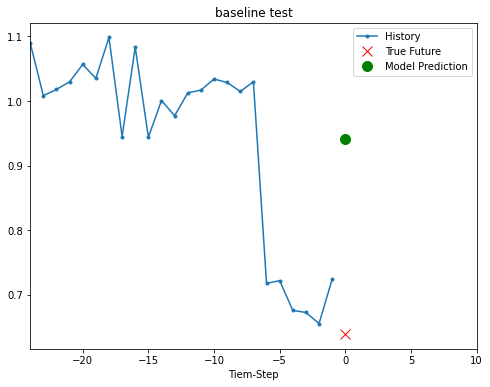

In [17]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'baseline test');

In [18]:
batch_size = 1440
buffer_size = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(batch_size).repeat()

In [19]:
single_step_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)])

single_step_model.compile(optimizer='adam', loss='mae')

In [20]:
for x, y in val_univariate.take(1):
    print(single_step_model.predict(x).shape)

(1416, 1)


In [21]:
interval = 200
epochs = 10
single_step_model.fit(train_univariate, epochs=epochs,
          steps_per_epoch=interval,
          validation_data=val_univariate,
          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 5s 19ms/step - loss: 0.7510 - val_loss: 0.2737
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2798 - val_loss: 0.2228
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2548 - val_loss: 0.2169
Epoch 4/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2504 - val_loss: 0.2134
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2469 - val_loss: 0.2115
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2434 - val_loss: 0.2101
Epoch 7/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2407 - val_loss: 0.2082
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2387 - val_loss: 0.2078
Epoch 9/10
200/200 [==============================] - 3s 15ms/step - loss: 0.2368 - val_loss: 0.2064
Epoch 10/10
200/200 [==============================] - 3s 16ms/step - loss: 0.2333 - val_lo

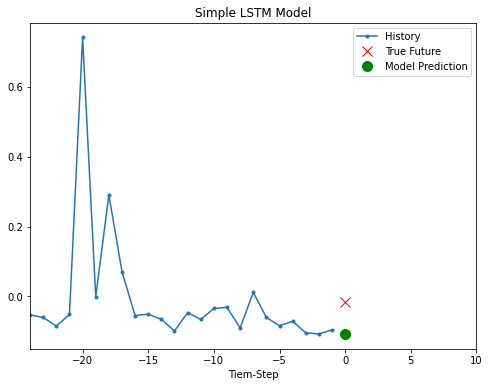

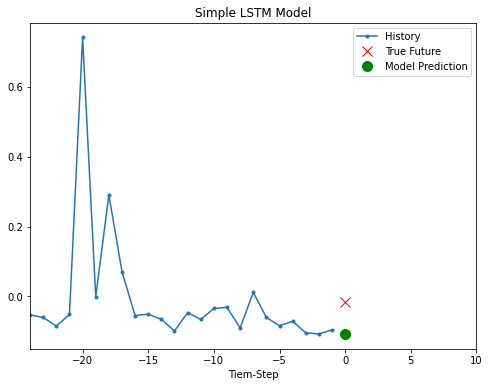

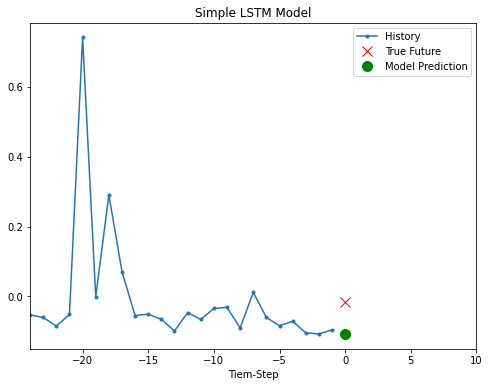

In [22]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(), 
                      single_step_model.predict(x)[0]], 0 , 'Simple LSTM Model')
    plot.show()

In [23]:
features_considered = ['value']

In [24]:
features = df[features_considered]
features.index = df['datetime']
features.head()

,value
datetime,
2021-12-01 00:00:00,418.50
2021-12-01 00:01:00,409.95
2021-12-01 00:02:00,410.96
2021-12-01 00:03:00,412.20
2021-12-01 00:04:00,415.01


array([<AxesSubplot:xlabel='datetime'>], dtype=object)

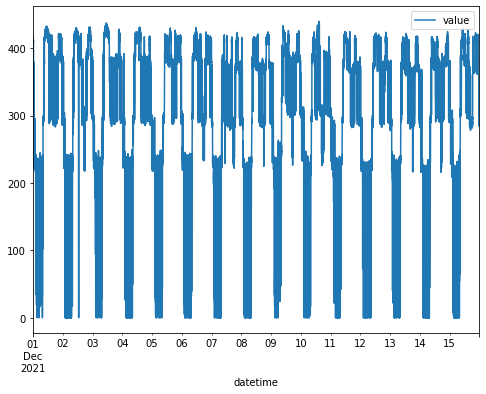

In [25]:
features.plot(subplots=True)

#### 예측 비교

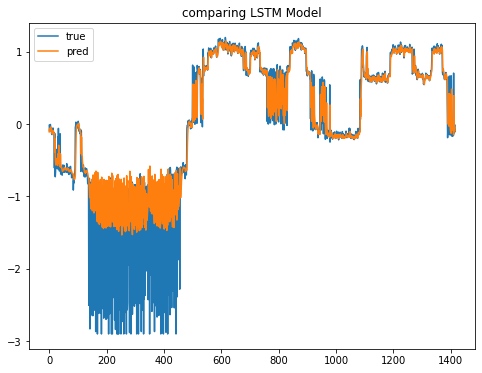

In [28]:
pred = single_step_model.predict(x)
true = y.numpy()
plt.title("comparing LSTM Model")

plt.plot(true)
plt.plot(pred)
plt.legend(['true', 'pred']);

#### MAE(Mean Absolute Error)

In [27]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(true, pred)

0.20532401593471858

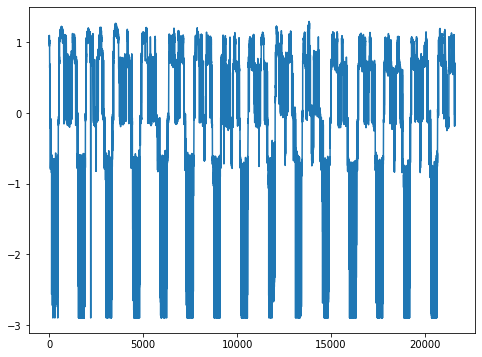

In [31]:
plt.plot(uni_data_norm)
